In [1]:
bucket_name = 'my-new-bucket-xx'
# Read in the cleaned data
# While developing the feature engineering code just read 
# in the data for stocks starting with "A"
sdf = spark.read.parquet('gs://'+bucket_name+'/cleaned/A*.US_D1.csv.parquet')

sdf.printSchema()

root
 |-- stock_symbol: string (nullable = true)
 |-- datetime: date (nullable = true)
 |-- open: double (nullable = true)
 |-- high: double (nullable = true)
 |-- low: double (nullable = true)
 |-- close: double (nullable = true)
 |-- volume: integer (nullable = true)
 |-- bbands_20_upperband: double (nullable = true)
 |-- bbands_20_middleband: double (nullable = true)
 |-- bbands_20_lowerband: double (nullable = true)
 |-- dema_20: double (nullable = true)
 |-- ema_20: double (nullable = true)
 |-- ema_60: double (nullable = true)
 |-- kama_20: double (nullable = true)
 |-- kama_60: double (nullable = true)
 |-- ma_20: double (nullable = true)
 |-- ma_60: double (nullable = true)
 |-- sma_20: double (nullable = true)
 |-- sma_60: double (nullable = true)
 |-- tema_20: double (nullable = true)
 |-- tema_60: double (nullable = true)
 |-- adx_20: double (nullable = true)
 |-- adx_60: double (nullable = true)
 |-- macd_20_40_10_macd: double (nullable = true)
 |-- macd_60_120_30_macd: dou

In [2]:
# Count of records
sdf.count()

286293

In [3]:
sdf.show(5)

24/05/17 18:51:16 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+------------+----------+-----+-----+-----+-----+-------+-------------------+--------------------+-------------------+-------+------+------+-------+-------+-----+-----+------+------+-------+-------+------+------+------------------+-------------------+------+------+--------------+
|stock_symbol|  datetime| open| high|  low|close| volume|bbands_20_upperband|bbands_20_middleband|bbands_20_lowerband|dema_20|ema_20|ema_60|kama_20|kama_60|ma_20|ma_60|sma_20|sma_60|tema_20|tema_60|adx_20|adx_60|macd_20_40_10_macd|macd_60_120_30_macd|rsi_20|rsi_60|next_day_close|
+------------+----------+-----+-----+-----+-----+-------+-------------------+--------------------+-------------------+-------+------+------+-------+-------+-----+-----+------+------+-------+-------+------+------+------------------+-------------------+------+------+--------------+
|        ADBE|1998-09-16|30.88|32.26|30.81|31.75|1403612|              30.64|               26.68|              22.73|  27.16| 28.07|  32.1|   26.3|  29.13|2

In [4]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

# List of numeric columns - these will be assembled into the vector directly


numeric_columns = ['open', 'high', 'low', 'close', 'volume', 
                    'bbands_20_upperband', 'bbands_20_middleband', 
                    'bbands_20_lowerband', 'dema_20', 'ema_20', 'ema_60', 
                    'kama_20', 'kama_60', 'ma_20', 'ma_60', 
                    'sma_20', 'sma_60', 
                    'tema_20', 'tema_60', 'adx_20', 'adx_60', 
                    'macd_20_40_10_macd', 'macd_60_120_30_macd', 
                    'rsi_20', 'rsi_60']
# Categorical columns will need to be indexed and then one-hot encoded
categorical_columns = ['stock_symbol']

# Split the data (sdf) into training and test sets
trainingData, testData = sdf.randomSplit([0.70, 0.3], seed=42)

# Create an indexer for the stock symbol
indexer = StringIndexer(inputCol='stock_symbol', outputCol='stock_symbol_index')

# Create an encoder for stock_symbol_index column
encoder = OneHotEncoder(inputCol='stock_symbol_index', outputCol='stock_symbol_encoded')

# Create an assembler for the individual feature vectors and the float/double columns
assembler = VectorAssembler(inputCols=numeric_columns + ['stock_symbol_encoded'], outputCol="features")

# Create a Ridge Regression Estimator
ridge_reg = LinearRegression(featuresCol='features', labelCol='next_day_close')

# Create a regression evaluator (to get RMSE, R2, RME, etc.)
evaluator = RegressionEvaluator(labelCol='next_day_close', metricName='rmse')

# Create the pipeline
regression_pipe = Pipeline(stages=[indexer, encoder, assembler, ridge_reg])

# Create a grid to hold hyperparameters 
grid = (ParamGridBuilder()
        .addGrid(ridge_reg.regParam, [0.001, 0.01, 0.1, 1, 10]) 
        .addGrid(ridge_reg.elasticNetParam, [0, 0.25, 0.5, 0.75, 1]) 
        .addGrid(ridge_reg.fitIntercept, [True, False]) 
        .build())

# Create the CrossValidator using the hyperparameter grid
cv = CrossValidator(estimator=regression_pipe, 
                    estimatorParamMaps=grid, 
                    evaluator=evaluator, 
                    numFolds=3,
                    seed=42)

# Train the models
all_models  = cv.fit(trainingData)

# Show the average performance over the three folds for each grid combination
print(f"Average metric {all_models.avgMetrics}")

# Get the best model from all of the models trained
bestModel = all_models.bestModel

# Use the model 'bestModel' to predict the test set
test_results = bestModel.transform(testData)

# Show a sample of test results with 'next_day_close' and 'predicted'
test_results.select(['stock_symbol', 'datetime','open', 'high', 'low', 'close', 'volume', 'next_day_close', 'prediction']).show(truncate=False)


Average metric [3.282473891882224, 3.2823577012338867, 4.338966522972445, 4.836319990704074, 4.188767085090038, 4.939735535097658, 4.1527971031800055, 4.886546433348625, 4.56566420356445, 4.934826660255232, 3.3051415604637895, 3.305017822009901, 4.364866611238109, 4.851802370287733, 4.453506599477518, 4.742588550003936, 4.40148421163434, 4.911073503860735, 4.273313184215941, 4.926814454190507, 3.4914830650820132, 3.4913022794905397, 4.053048724331411, 4.804066876978195, 4.45403780490182, 4.8300593982637965, 4.391026539018338, 4.7964913001156235, 4.48973392827682, 4.789816181002573, 4.253588272682557, 4.253579327582669, 4.521501014025202, 4.774919729431481, 4.569620005610871, 4.820566961092237, 4.55621147025268, 4.78828775278049, 4.631803158718343, 5.158036815255625, 5.071724158442238, 5.0741433461016365, 6.161816053078899, 6.112201721268413, 7.549268327347895, 7.466102047334412, 9.236349989107095, 9.111361452913004, 11.2629803593737, 10.434688424486685]


+------------+----------+-----+-----+-----+-----+-------+--------------+------------------+
|stock_symbol|datetime  |open |high |low  |close|volume |next_day_close|prediction        |
+------------+----------+-----+-----+-----+-----+-------+--------------+------------------+
|ADBE        |1998-09-18|31.38|31.88|31.06|31.75|529100 |31.88         |31.9591671477807  |
|ADBE        |1998-09-24|33.5 |34.57|33.25|33.56|532901 |33.38         |33.90309803065034 |
|ADBE        |1998-09-28|34.0 |35.69|33.94|34.88|760304 |35.0          |35.16621200721172 |
|ADBE        |1998-09-29|35.0 |35.25|34.5 |35.0 |925902 |34.72         |35.131846506388705|
|ADBE        |1998-10-05|33.5 |34.0 |31.75|32.5 |2308704|32.03         |32.60521415464074 |
|ADBE        |1998-10-06|33.0 |33.0 |31.0 |32.03|974500 |31.01         |31.994255616810698|
|ADBE        |1998-10-07|31.75|32.19|30.12|31.01|995406 |31.5          |31.05580255050806 |
|ADBE        |1998-10-13|33.75|34.75|32.88|33.63|1821800|32.38         |33.76387

In [5]:

# RMSE measures the differences between what the model predicted ('prediction') and the actual values ('').
rmse = evaluator.evaluate(test_results, {evaluator.metricName:'rmse'})
# R-Squared measures how much of the variability in the target variable (tip) can be explained by the model
r2 =evaluator.evaluate(test_results,{evaluator.metricName:'r2'})
print(f"RMSE: {rmse}  R-squared:{r2}")

# bestModel.coeff.
# bestModel = all_models.bestModel
# print("Coeeff ", bestModel.coeff)
# bestModel = all_models.bestModel.stages(4)

print(bestModel.stages)

coefficients = bestModel.stages[3].coefficients
print("bestModel coefficients", coefficients)
intercept = bestModel.stages[3].intercept
print("bestModel intercept", intercept)

# for i in range(len(testData.columns)-1):
#    print(testData.columns[i],coefficients[i])

# print(testData.columns[:-1])
# print(map(abs, coefficients))
# feature_importance = sorted(list(zip(testData.columns[:-1], map(abs, coefficients))), key=lambda x: x[1], reverse=True)

# print("Feature Importance:")
# for feature, importance in feature_importance:
#      print("  {}: {:.3f}".format(feature, importance))


RMSE: 3.0264238749463535  R-squared:0.9995877563622433
[StringIndexerModel: uid=StringIndexer_bfbf34768eda, handleInvalid=error, OneHotEncoderModel: uid=OneHotEncoder_b40c5cebf416, dropLast=true, handleInvalid=error, VectorAssembler_d7522e569bed, LinearRegressionModel: uid=LinearRegression_20770eb9d542, numFeatures=76]
bestModel coefficients [-0.1471944753093254,0.16723314519982113,0.17407669253282568,0.7843767371538599,-5.4995970826494225e-11,0.0023758516867256273,0.004081349844163807,0.006215652559251746,-0.017539324370972,-0.035651928636704085,-0.06890431119056374,-0.002612683859221582,-0.005917263584394313,0.004081349896307866,-0.007966930233576145,0.004081349896253019,-0.00796693024454068,0.09512063920859708,0.052964529217120505,-0.002207658792208034,0.002978492773577911,-0.3388558359635083,0.009144023598175403,0.007712674903675781,-0.006982462034643057,0.07369935858406168,-0.058782208622281854,-0.04048590912967065,-0.02546040532159158,-0.04904235899952861,-0.035026302388320024,-0

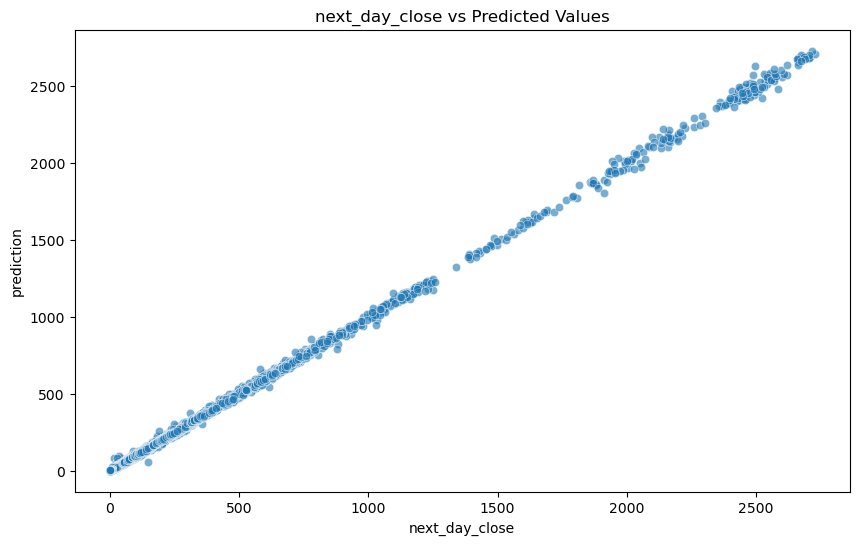

In [6]:
# Visualize regression results
import seaborn as sns
import matplotlib.pyplot as plt  # Importing matplotlib for plt.show()

# The Spark dataframe test_results holds the original 'next_day_close' as well as the 'prediction'
# Select and convert to a Pandas dataframe
df = test_results.select('next_day_close', 'prediction').toPandas()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='next_day_close', y='prediction', data=df, alpha=0.6)
plt.title('next_day_close vs Predicted Values')


# Set the style for Seaborn plots
sns.set_style("white")


# Show the plot
plt.show()



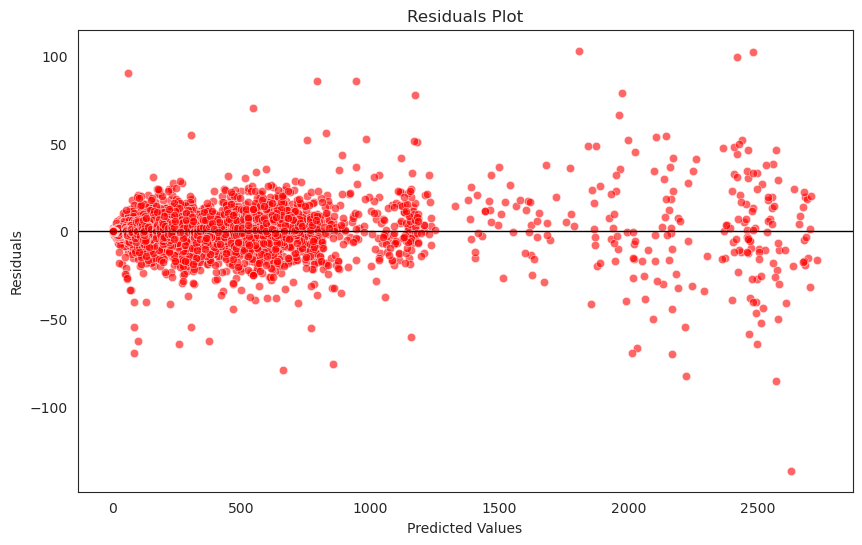

In [7]:
# Calculate residuals
df = test_results.select('next_day_close', 'prediction').toPandas()
df['residuals'] = df['next_day_close'] - df['prediction']

# Set the style for Seaborn plots
sns.set_style("white")

# Create the residuals plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='prediction', y='residuals', data=df, color='red', alpha=0.6)
plt.axhline(0, color='black', linewidth=1)
plt.title('Residuals Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()


In [8]:
# Identify the specific outlier
outlier = df[(df['prediction'] > 490) & (df['prediction'] < 510) & (df['residuals'] < -390) & (df['residuals'] > -410)]
print(outlier)


Empty DataFrame
Columns: [next_day_close, prediction, residuals]
Index: []


In [9]:
# SQL CODES TO FIND SPECIFIC DATE TIME
from pyspark.sql.functions import col

sdf.select('stock_symbol', 'datetime', 'close', 'next_day_close') \
   .filter(col('datetime') > '2023-01-01') \
   .show(20)


+------------+----------+------+--------------+
|stock_symbol|  datetime| close|next_day_close|
+------------+----------+------+--------------+
|        ADBE|2023-01-03| 336.9|        341.53|
|        ADBE|2023-01-04|341.53|        328.45|
|        ADBE|2023-01-05|328.45|         332.9|
|        ADBE|2023-01-06| 332.9|        332.75|
|        ADBE|2023-01-07|332.75|        342.04|
|        ADBE|2023-01-09|342.04|        338.86|
|        ADBE|2023-01-10|338.86|        342.93|
|        ADBE|2023-01-11|342.93|        344.38|
|        ADBE|2023-01-12|344.38|        344.36|
|        ADBE|2023-01-13|344.36|        344.38|
|        ADBE|2023-01-14|344.38|        344.23|
|        ADBE|2023-01-17|344.23|        341.34|
|        ADBE|2023-01-18|341.34|        342.46|
|        ADBE|2023-01-19|342.46|         356.3|
|        ADBE|2023-01-20| 356.3|        356.38|
|        ADBE|2023-01-21|356.38|        364.94|
|        ADBE|2023-01-23|364.94|        361.65|
|        ADBE|2023-01-24|361.65|        

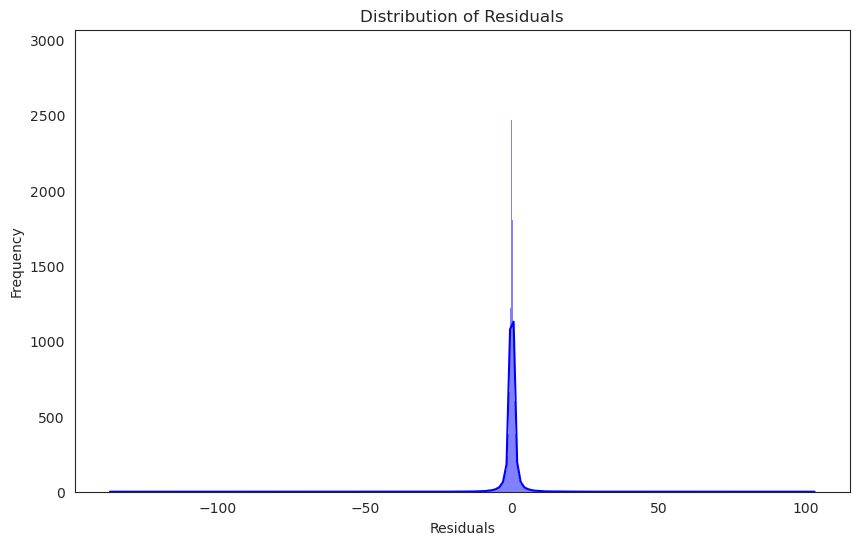

In [10]:
#Distribution of Residuals

plt.figure(figsize=(10, 6))
sns.histplot(df['residuals'], kde=True, color='blue')
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

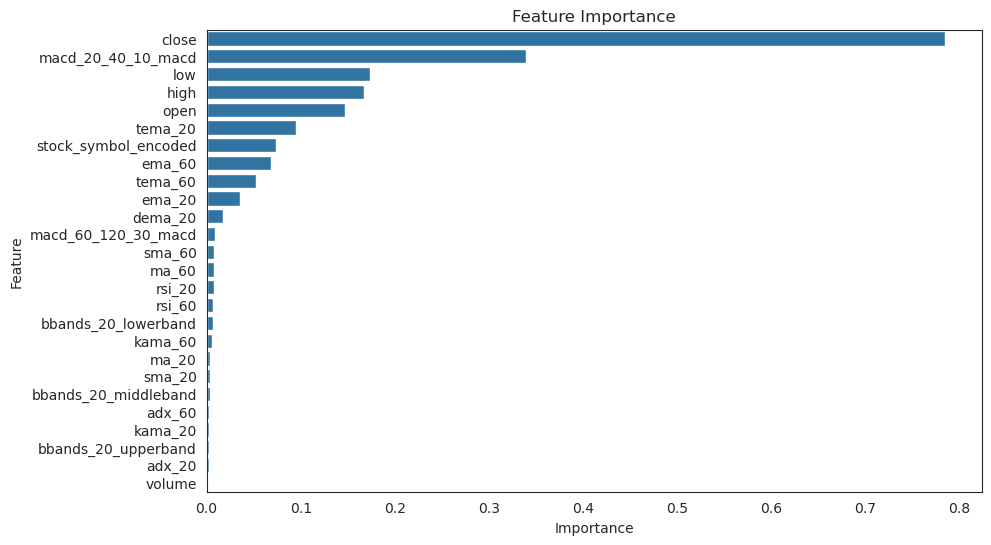

In [11]:
# Extract feature importances from the best model

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# existing code
coefficients = bestModel.stages[-1].coefficients.toArray()
feature_names = numeric_columns + ['stock_symbol_encoded']
feature_importance = pd.DataFrame(list(zip(feature_names, coefficients)), columns=['Feature', 'Coefficient'])
feature_importance['Importance'] = feature_importance['Coefficient'].apply(lambda x: abs(x))
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()
